# Hands-on Session with Prolog
## Artificial Intelligence Fundamentals 2023/24
Elia Piccoli (elia.piccoli@phd.unipi.it)

---

We can reuse the virtual environment created in the previous session.

To recall, the packages needed are: _nle_, _minihack_, _matplotlib_, _notebook_

For today lesson we will use _pyswip_ - https://github.com/yuce/pyswip - that is a Python - SWI-Prolog bridge enabling to query SWI-Prolog in your Python programs.

### >> **Install** <<
Please read carefully the install instructions!

You can find them here: https://github.com/yuce/pyswip#install

---

## Prolog and some examples

Import the Prolog class from the library that is used to handle our knowledge base.

In [59]:
from pyswip import Prolog

Add axioms to the KB.

_assertz_: adds an axiom at the end

_asserta_: adds an axiom at the beginning

Keep in mind that order is important!

In [60]:
KB = Prolog()
KB.assertz("father(michael,john)")
KB.assertz("father(michael,gina)")
KB.asserta("father(giuseppe,mario)")

Query the KB to obtain answers based on the axioms.

In [61]:
list(KB.query("father(michael,X)"))

[{'X': 'john'}, {'X': 'gina'}]

In [62]:
list(KB.query("father(giuseppe,Y)"))

[{'Y': 'mario'}]

In [63]:
list(KB.query("father(giuseppe,antonio)")), list(KB.query("father(giuseppe,mario)"))

([], [{}])

In [64]:
for soln in KB.query("father(X,Y)"):
    print(soln["X"], "is the father of", soln["Y"])

giuseppe is the father of mario
michael is the father of john
michael is the father of gina


With _retractall()_ is possible to remove all axioms that correspond to the given definition.

`_` means all possible values. 

In [65]:
KB.retractall("father(_,_)")

Now the KB is empty so the query wont retrieve any solution.

In [66]:
list(KB.query("father(michael,X)"))

[]

We must assert again all the axioms.

In [67]:
KB.assertz("father(michael,john)")
KB.assertz("father(michael,gina)")
KB.asserta("father(giuseppe,mario)")

In this case we retract only the axioms where the father is `giuseppe`.

In [68]:
KB.retractall("father(giuseppe,_)")

In [69]:
for soln in KB.query("father(X,Y)"):
    print(soln["X"], "is the father of", soln["Y"])

michael is the father of john
michael is the father of gina


In [70]:
KB.retractall("father(_,_)")

---

We can also write the prolog rules in a separate file and load it.

In [71]:
KB = Prolog()
KB.consult('simple_rules.pl')

It is possible to assert new axioms and add them to the KB.

In [72]:
KB.assertz("father(michael,john)")
KB.assertz("father(michael,gina)")

In [73]:
for soln in KB.query("father(X,Y)"):
    print(soln["X"], "is the father of", soln["Y"])

giuseppe is the father of mario
giuseppe is the father of luigi
michael is the father of john
michael is the father of gina


We can query the KB and obtain the result of different predicates.

In [74]:
print(list(KB.query("is_father_of_two(X)")))

[{'X': 'giuseppe'}, {'X': 'giuseppe'}, {'X': 'michael'}, {'X': 'michael'}]


In [75]:
print(list(KB.query("brothers(X, Y)")))

[{'X': 'mario', 'Y': 'luigi'}, {'X': 'luigi', 'Y': 'mario'}, {'X': 'john', 'Y': 'gina'}, {'X': 'gina', 'Y': 'john'}]


In [76]:
KB.retractall("father(_,_)")

---

## Today Hands-on

We want to create the set of rules to perform different actions in order to achieve the final goal.

In [77]:
import gym
import time
import matplotlib.pyplot as plt
from pyswip import Prolog
from utils import create_level, define_reward, process_state, perform_action, show_match

Define some parameters to customize the experiments.

In [78]:
H = 10
W = 10
NUM_EPISODES = 15
MAX_STEPS = 30
MONSTER = 'kobold'
WEAPON = 'tsurugi'
PATH = 'kb.pl'

Create the `des_file` description of the environment and define the reward function.

In [79]:
des_file = create_level(width=W, height=H, monster=MONSTER, weapon=WEAPON)
reward_manager = define_reward()

Create the environment.

In [80]:
env = gym.make('MiniHack-Skill-Custom-v0',
               character="sam-hum-neu-mal",
               observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel'),
               des_file=des_file,
               reward_manager=reward_manager)

In [81]:
obs = env.reset()
env.render()


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                  ..........                                    
                                  ..........                                    
                                  .........@                                    
                                  ..........                                    
                           

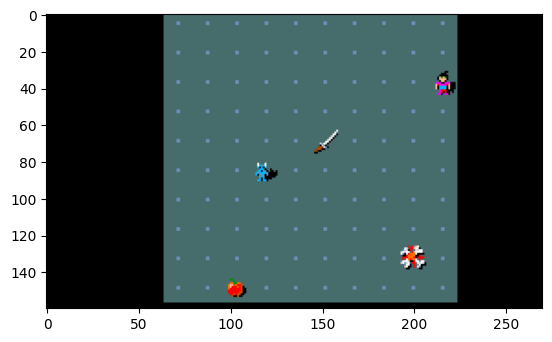

In [82]:
plt.imshow(obs['pixel'][115:275, 480:750])

Initialize the knowledge base.

In [83]:
KB = Prolog()
KB.consult(PATH)

#### Main code
- Perform `NUM_EPISODES` experiences in the environment.
- Use `Prolog` to define the axioms and choose the action to perform.
- The main goal is to _reach and eat_ the `apple`.

Episode 14 - 8 steps
End status: TASK_SUCCESSFUL
Final reward: 2.0
After 15 episodes, mean return is 1.7986666666666666
The rewards of the episodes are: [2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.99, 2.0, 2.0, 2.0, 2.0, -0.01, 2.0, 2.0]


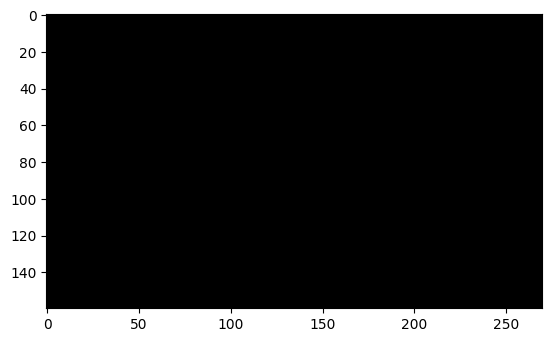

In [84]:
rewards = []
for episode in range(NUM_EPISODES):
    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False

    # Main loop
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb 
        process_state(obs, KB, MONSTER, WEAPON)

        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
        try:
            action = list(KB.query('action(X)'))[0]
            action = action['X']
            # print(f'>> Current action from Prolog: {action}')
        except Exception as e:
            action = None

        # Perform the action in the environment
        if action:
            obs, reward, done, info = perform_action(action, env)
            ep_states.append(obs['pixel'])
            # env.render()
        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break

        steps += 1

    # Display game with interface
    show_match(ep_states)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')
    time.sleep(0.75)

    rewards.append(reward)

    # reset the environment and retract axioms that may cause errors
    obs = env.reset()
    KB.retractall('stepping_on(agent,_,_)')


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)